In [1]:
!pip install torch torchvision timm tqdm scikit-learn matplotlib opencv-python

In [2]:
import os
import numpy as np
import pandas as pd
import random
import shutil
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from tqdm import tqdm
from copy import deepcopy
import timm
import cv2

import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:
!unzip /content/brain_tumor_dataset.zip

Archive:  /content/brain_tumor_dataset.zip
   creating: brain_tumor_dataset/
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/N_1.jpg  
  inflating: brain_tumor_dataset/no/N_10.jpg  
  inflating: brain_tumor_dataset/no/N_11.jpg  
  inflating: brain_tumor_dataset/no/N_12.jpg  
  inflating: brain_tumor_dataset/no/N_13.jpg  
  inflating: brain_tumor_dataset/no/N_14.jpg  
  inflating: brain_tumor_dataset/no/N_15.jpg  
  inflating: brain_tumor_dataset/no/N_16.jpg  
  inflating: brain_tumor_dataset/no/N_17.jpg  
  inflating: brain_tumor_dataset/no/N_18.jpg  
  inflating: brain_tumor_dataset/no/N_19.jpg  
  inflating: brain_tumor_dataset/no/N_2.jpg  
  inflating: brain_tumor_dataset/no/N_20.jpg  
  inflating: brain_tumor_dataset/no/N_21.jpg  
  inflating: brain_tumor_dataset/no/N_22.jpg  
  inflating: brain_tumor_dataset/no/N_23.jpg  
  inflating: brain_tumor_dataset/no/N_24.jpg  
  inflating: brain_tumor_dataset/no/N_25.jpg  
  inflating: brain_tumor_dataset/no/N_26.j

In [4]:
# Global settings
OPTIM_PARAMS = {"lr": 1e-5}
OPTIM = torch.optim.AdamW
CRITERIUM = torch.nn.CrossEntropyLoss
BATCH_SIZE = 4
IMAGE_SIZE = 256
N_EPOCHS = 50
PATIENCE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2 if torch.cuda.is_available() else 4
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
def prepare_data():
    """
    Prepare and split the dataset into train/val/test directories
    """
    # Source directories
    yes_dir = '/content/brain_tumor_dataset/yes'
    no_dir = '/content/brain_tumor_dataset/no'

    # Create output directories
    for split in ['train', 'val', 'test']:
        for class_name in ['yes', 'no']:
            os.makedirs(f'swin_data/{split}/{class_name}', exist_ok=True)

    # Process 'yes' class
    yes_files = os.listdir(yes_dir)
    random.shuffle(yes_files)
    train_size = int(0.7 * len(yes_files))
    val_size = int(0.15 * len(yes_files))

    # Split the files
    yes_train = yes_files[:train_size]
    yes_val = yes_files[train_size:train_size+val_size]
    yes_test = yes_files[train_size+val_size:]

    # Process 'no' class
    no_files = os.listdir(no_dir)
    random.shuffle(no_files)
    train_size = int(0.7 * len(no_files))
    val_size = int(0.15 * len(no_files))

    no_train = no_files[:train_size]
    no_val = no_files[train_size:train_size+val_size]
    no_test = no_files[train_size+val_size:]

    # Copy files to respective directories
    for files, src_dir, dest_split, class_name in [
        (yes_train, yes_dir, 'train', 'yes'),
        (yes_val, yes_dir, 'val', 'yes'),
        (yes_test, yes_dir, 'test', 'yes'),
        (no_train, no_dir, 'train', 'no'),
        (no_val, no_dir, 'val', 'no'),
        (no_test, no_dir, 'test', 'no')
    ]:
        for file in files:
            src = os.path.join(src_dir, file)
            dst = os.path.join(f'swin_data/{dest_split}/{class_name}', file)
            shutil.copy(src, dst)

    print("Data preparation complete!")
    print(f"Train: {len(yes_train)} yes, {len(no_train)} no")
    print(f"Val: {len(yes_val)} yes, {len(no_val)} no")
    print(f"Test: {len(yes_test)} yes, {len(no_test)} no")

def preprocess_image(img_path):
    """
    Preprocess an image by cropping to tumor region
    """
    # Read image
    image = cv2.imread(img_path)
    if image is None:
        return None

    # Convert BGR to GRAY
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # GuassianBlur
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Threshold
    thres = cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1]
    # Erode
    erode = cv2.erode(thres, None, iterations=2)
    # Dilate
    dilate = cv2.dilate(erode, None, iterations=2)

    # Find Contours
    contours = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    if not contours:
        return image  # Return original if no contours found

    c = max(contours, key=cv2.contourArea)

    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop image to contour
    try:
        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
        if new_image.size == 0:  # If cropping fails
            return image
        return new_image
    except:
        return image

def preprocess_dataset():
    """
    Preprocess all images in the dataset
    """
    for split in ['train', 'val', 'test']:
        for class_name in ['yes', 'no']:
            dir_path = f'swin_data/{split}/{class_name}'
            for filename in os.listdir(dir_path):
                img_path = os.path.join(dir_path, filename)
                processed_img = preprocess_image(img_path)
                if processed_img is not None:
                    cv2.imwrite(img_path, processed_img)

    print("Preprocessing complete!")

def plot_sample_images(dataset, classes, num_images=5):
    """
    Plot sample images from the dataset
    """
    fig, axs = plt.subplots(1, num_images*len(classes), figsize=(15, 3))
    fig.suptitle("Sample Images from Dataset")

    for i, class_name in enumerate(classes):
        class_samples = [(img, label) for img, label in dataset if label == i]
        for j in range(num_images):
            if j < len(class_samples):
                img, _ = class_samples[j]


                img_np = img.numpy().transpose((1, 2, 0))  # Convert to HWC format
                # Undo normalization for visualization
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = std * img_np + mean
                img_np = np.clip(img_np, 0, 1)

                ax = axs[i*num_images + j]
                ax.imshow(img_np)
                ax.axis('off')
                ax.set_title(class_name)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()



In [6]:
prepare_data()
preprocess_dataset()

Data preparation complete!
Train: 29 yes, 51 no
Val: 6 yes, 11 no
Test: 7 yes, 12 no
Preprocessing complete!


In [7]:
# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(5, translate=[0, .1], scale=[.9, 1.1]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(),
])

In [8]:
transform_val = transforms.Compose([
      transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

In [9]:
# Load datasets
train_dataset = ImageFolder('swin_data/train', transform=transform_train)
val_dataset = ImageFolder('swin_data/val', transform=transform_val)
test_dataset = ImageFolder('swin_data/test', transform=transform_val)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

# Show class information
class_names = train_dataset.classes
print("Classes:", class_names)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Classes: ['no', 'yes']
Number of training samples: 80
Number of validation samples: 17
Number of test samples: 19


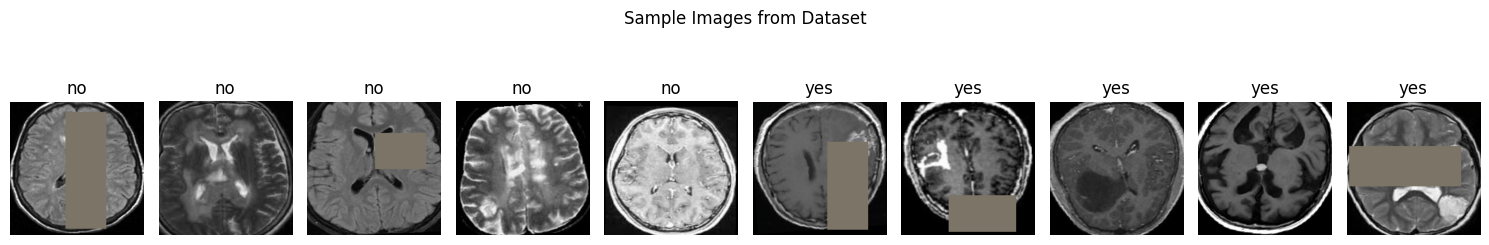

Creating SwinV2 model on cuda...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/792M [00:00<?, ?B/s]

In [10]:
# Visualize some sample images
plot_sample_images(train_dataset, class_names)

# Create model
print(f"Creating SwinV2 model on {DEVICE}...")
# model = timm.create_model('swinv2_tiny_window8_256.ms_in1k', pretrained=True)
model = timm.create_model('swinv2_large_window12to16_192to256.ms_in22k_ft_in1k', pretrained=True)
# Modify the final fully connected layer for binary classification
model.head.fc = nn.Linear(model.head.fc.in_features, len(class_names))

# Move model to device
model = model.to(DEVICE)

# Set up optimizer and loss function
optimizer = OPTIM(model.parameters(), **OPTIM_PARAMS)
criterion = CRITERIUM()

# Train the model
best_model = deepcopy(model)
best_acc = 0
patience_counter = 0
train_losses, val_losses, val_accuracies = [], [], []

In [11]:
print("Starting training...")
start_time = time.time()

for epoch in range(N_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    train_total = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS} - Training"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_total += x.size(0)

    train_loss /= train_total
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS} - Validation"):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Forward pass
            outputs = model(x)
            loss = criterion(outputs, y)

            # Statistics
            val_loss += loss.item() * x.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == y).sum().item()
            val_total += y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{N_EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = deepcopy(model)
        patience_counter = 0
        print(f"New best model found with accuracy: {best_acc:.4f}")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered after epoch {epoch+1}")
        break

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Starting training...


Epoch 1/50 - Validation: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch 1/50 - Train Loss: 0.5642, Val Loss: 0.3636, Val Acc: 0.8235
New best model found with accuracy: 0.8235


Epoch 2/50 - Validation: 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


Epoch 2/50 - Train Loss: 0.4332, Val Loss: 0.1797, Val Acc: 0.9412
New best model found with accuracy: 0.9412


Epoch 3/50 - Validation: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]


Epoch 3/50 - Train Loss: 0.2540, Val Loss: 0.0619, Val Acc: 1.0000
New best model found with accuracy: 1.0000


Epoch 4/50 - Validation: 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Epoch 4/50 - Train Loss: 0.1237, Val Loss: 0.0826, Val Acc: 0.9412


Epoch 5/50 - Validation: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Epoch 5/50 - Train Loss: 0.1776, Val Loss: 0.0247, Val Acc: 1.0000


Epoch 6/50 - Validation: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


Epoch 6/50 - Train Loss: 0.0953, Val Loss: 0.0979, Val Acc: 0.9412


Epoch 7/50 - Validation: 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]

Epoch 7/50 - Train Loss: 0.1990, Val Loss: 0.2030, Val Acc: 0.8824
Early stopping triggered after epoch 7
Training completed in 79.97 seconds


Best model saved to 'swinv2_brain_tumor_model.pth'


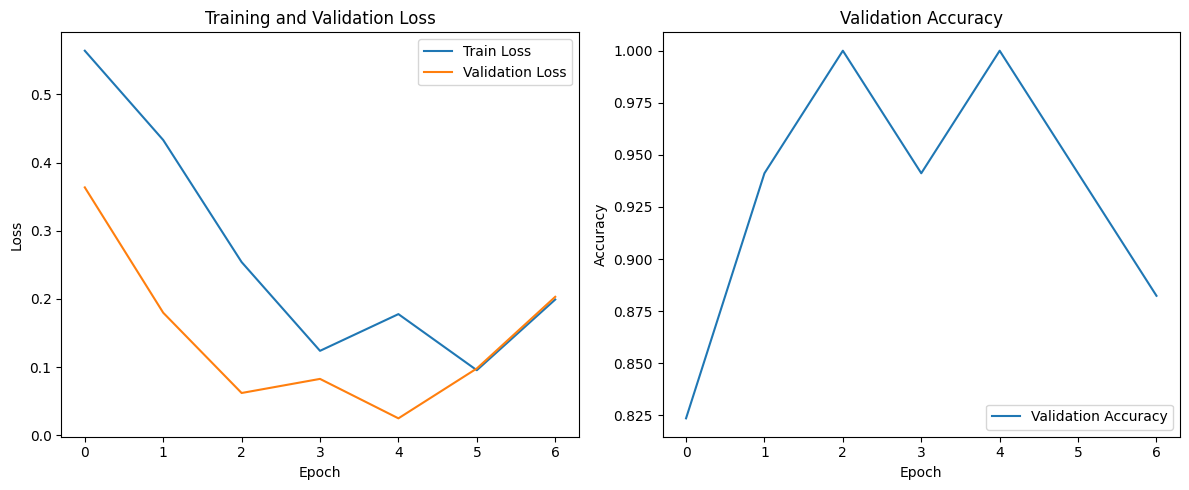

In [12]:
# Save the best model
torch.save(best_model.state_dict(), 'swinv2_brain_tumor_model.pth')
print("Best model saved to 'swinv2_brain_tumor_model.pth'")

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('swinv2_training_curves.png')
plt.show()

In [13]:
# Evaluate on test set
print("Evaluating on test set...")
model = best_model
model.eval()

# Collect predictions
y_true = []
y_pred_probs = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Evaluating on test set...


Testing: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]

Test Accuracy: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

          no       1.00      1.00      1.00        12
         yes       1.00      1.00      1.00         7

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



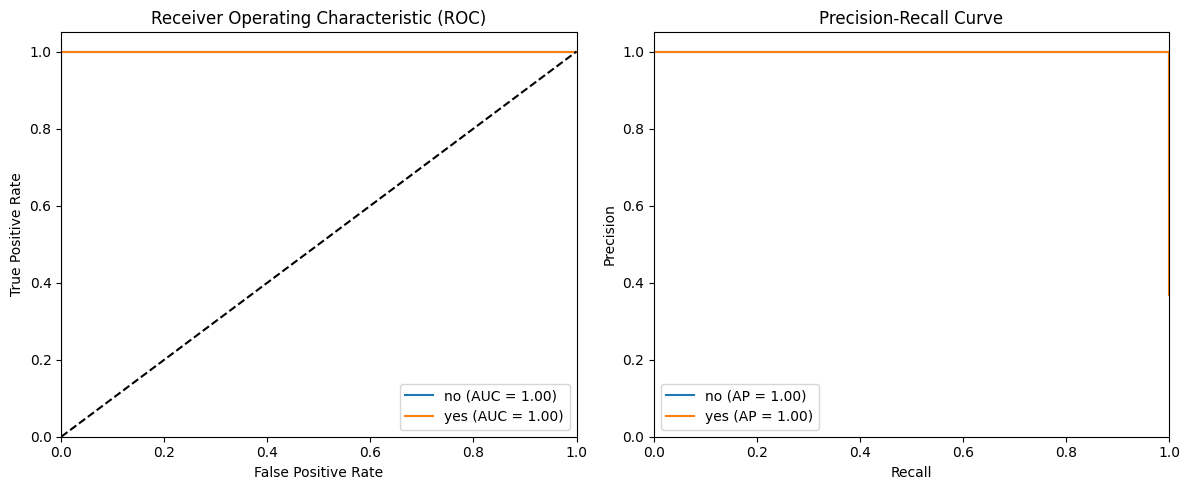

In [14]:
# Plot ROC curves and Precision-Recall curves
plt.figure(figsize=(12, 5))

# ROC curve
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_true == i, y_pred_probs[:, i])

# Plot ROC curves
plt.subplot(1, 2, 1)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

# Plot Precision-Recall curves
plt.subplot(1, 2, 2)
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.savefig('swinv2_performance_curves.png')
plt.show()


In [16]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 21.4 MB/s eta 0:00:00


Applying all enhancement techniques to sample image...


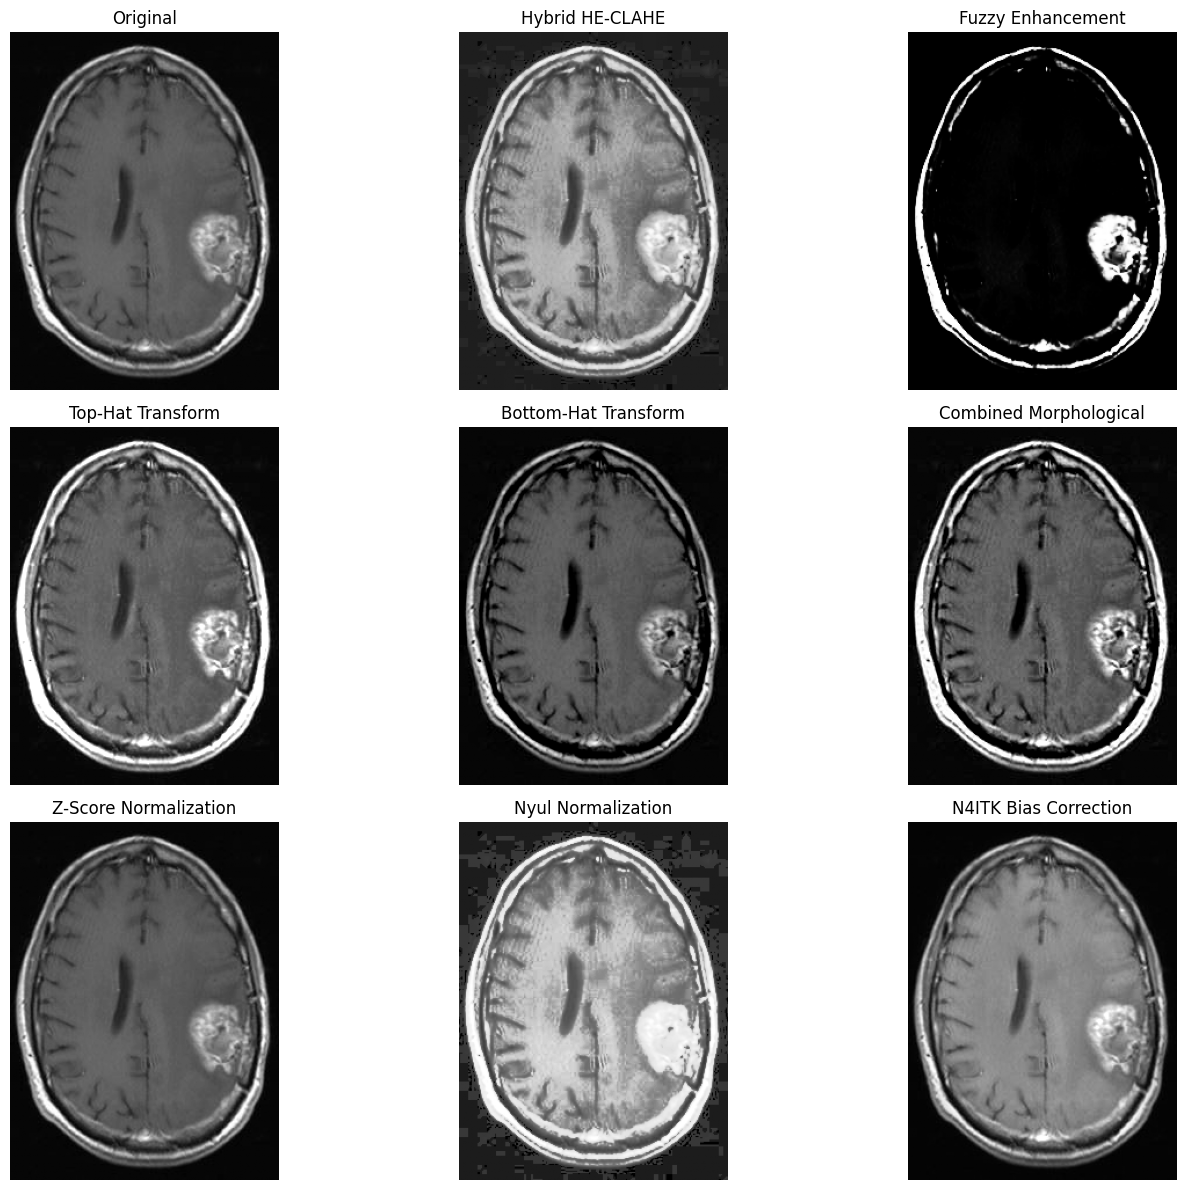

Generating augmented samples...


/tmp/ipython-input-3084481551.py:212: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (standard_landmarks[i + 1] - standard_landmarks[i]) / (landmarks[i + 1] - landmarks[i])
/tmp/ipython-input-3084481551.py:213: RuntimeWarning: invalid value encountered in multiply
  normalized[mask] = standard_landmarks[i] + slope * (gray[mask] - landmarks[i])


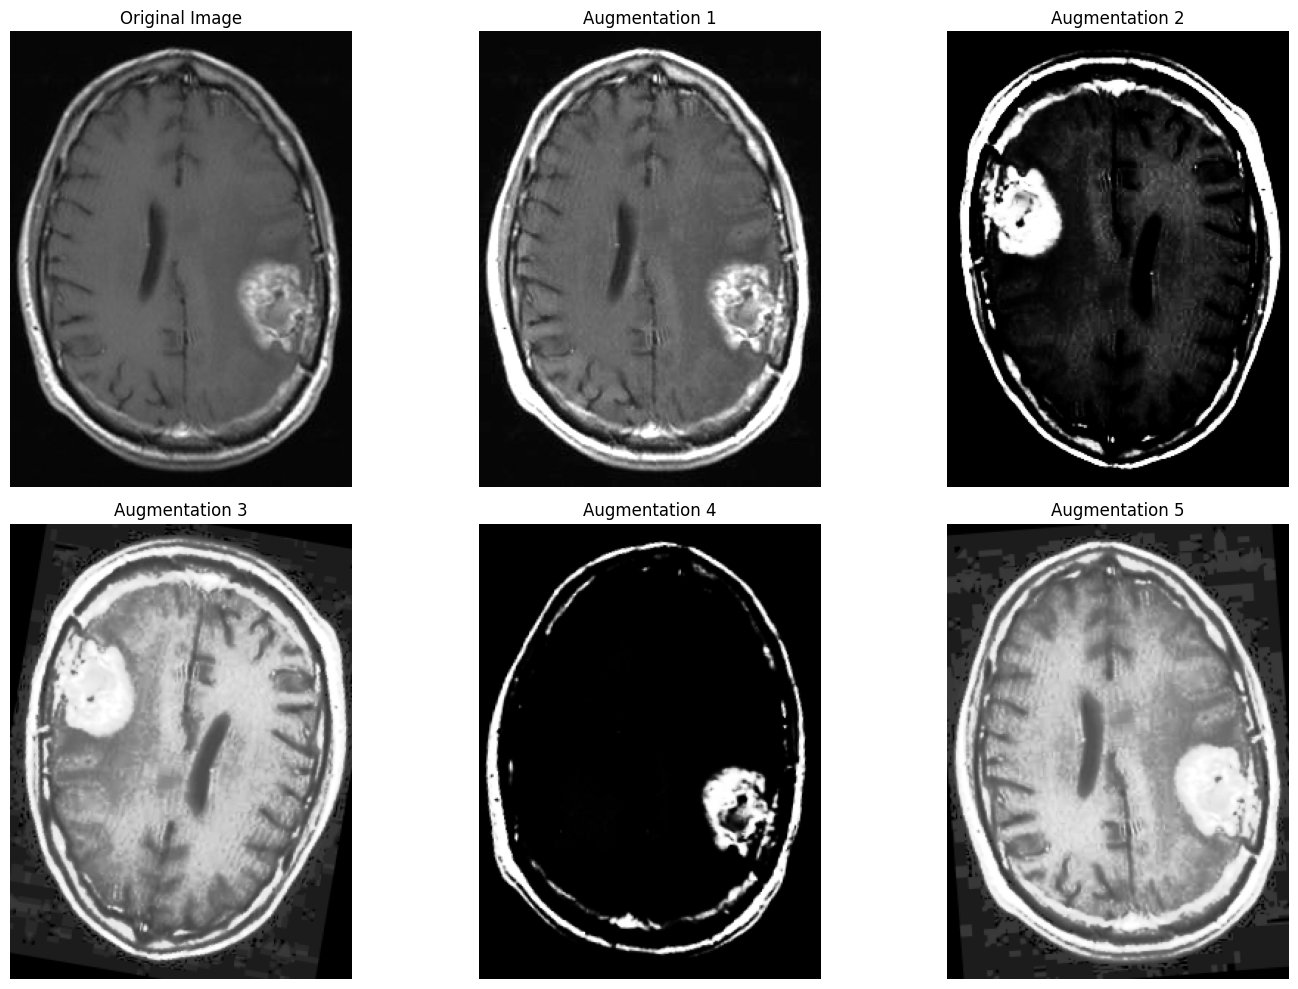


Augmenting full dataset (sample)...
Processing tumor images...
Processing non-tumor images...
Done! Check the Dataset/augmented_enhanced directory for results.


In [17]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure, morphology, filters, util
from skimage.filters import rank
from skimage.morphology import disk, ball, opening, closing, dilation, erosion
import SimpleITK as sitk
from scipy import ndimage
import random
from tqdm import tqdm

class MedicalImageEnhancer:
    """
    A class containing advanced image enhancement techniques for medical images.
    """

    def __init__(self, visualization=True):
        """
        Initialize the enhancer.

        Args:
            visualization (bool): Whether to enable visualization capabilities
        """
        self.visualization = visualization

    def hybrid_he_clahe(self, image, clip_limit=2.0, tile_grid_size=(8, 8), he_weight=0.5):
        """
        Apply a hybrid of global histogram equalization and CLAHE.

        Args:
            image: Input image
            clip_limit: Clipping limit for CLAHE
            tile_grid_size: Tile grid size for CLAHE
            he_weight: Weight for histogram equalization (0-1)

        Returns:
            Enhanced image
        """
        # Convert to grayscale if needed
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Apply global histogram equalization
        he_image = cv2.equalizeHist(gray)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        clahe_image = clahe.apply(gray)

        # Combine the two enhanced images with weighted average
        hybrid_image = cv2.addWeighted(he_image, he_weight, clahe_image, 1 - he_weight, 0)

        return hybrid_image

    def fuzzy_enhancement(self, image, membership_range=(0.3, 0.7)):
        """
        Enhance image using fuzzy logic techniques.

        Args:
            image: Input image
            membership_range: Tuple with (low, high) membership thresholds

        Returns:
            Enhanced image
        """
        # Ensure image is grayscale and normalized to [0,1]
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        normalized = gray.astype(float) / 255.0

        # Create fuzzy membership function (S-function)
        def s_function(x, a, b, c):
            result = np.zeros_like(x, dtype=float)

            # S-function definition
            mask1 = (x <= a)
            mask2 = (x > a) & (x <= b)
            mask3 = (x > b) & (x <= c)
            mask4 = (x > c)

            result[mask1] = 0
            result[mask2] = 2 * ((x[mask2] - a) / (c - a)) ** 2
            result[mask3] = 1 - 2 * ((x[mask3] - c) / (c - a)) ** 2
            result[mask4] = 1

            return result

        # Create membership map
        a, c = membership_range
        b = (a + c) / 2
        membership = s_function(normalized, a, b, c)

        # Enhance using INT operator (Intensification)
        enhanced = np.zeros_like(normalized)
        mask1 = (membership <= 0.5)
        mask2 = (membership > 0.5)

        enhanced[mask1] = 2 * membership[mask1] ** 2
        enhanced[mask2] = 1 - 2 * (1 - membership[mask2]) ** 2

        # Scale back to [0, 255]
        result = np.clip(enhanced * 255, 0, 255).astype(np.uint8)

        return result

    def morphological_enhancement(self, image, method='tophat', kernel_size=15):
        """
        Enhance image using morphological operations.

        Args:
            image: Input image
            method: 'tophat', 'bottomhat', or 'both'
            kernel_size: Size of the structuring element

        Returns:
            Enhanced image
        """
        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Create structuring element
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

        if method == 'tophat':
            # Top-hat transform: Removes dark regions, enhances bright structures
            result = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
            # Add back to original for enhancement
            enhanced = cv2.add(gray, result)

        elif method == 'bottomhat':
            # Bottom-hat transform: Removes bright regions, enhances dark structures
            result = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
            # Subtract from original for enhancement
            enhanced = cv2.subtract(gray, result)

        elif method == 'both':
            # Combine both top-hat and bottom-hat for enhanced contrast
            tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
            bottomhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
            enhanced = cv2.add(gray, tophat)
            enhanced = cv2.subtract(enhanced, bottomhat)

        else:
            raise ValueError("Method must be 'tophat', 'bottomhat', or 'both'")

        return enhanced

    def intensity_normalization(self, image, method='zscore', target_mean=None, target_std=None,
                              p_min=1, p_max=99):
        """
        Normalize image intensity.

        Args:
            image: Input image
            method: 'zscore', 'nyul', or 'minmax'
            target_mean: Target mean for Z-score normalization (optional)
            target_std: Target standard deviation for Z-score normalization (optional)
            p_min: Minimum percentile for min-max normalization
            p_max: Maximum percentile for min-max normalization

        Returns:
            Normalized image
        """
        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        gray = gray.astype(float)

        if method == 'zscore':
            # Z-score normalization
            mean = np.mean(gray)
            std = np.std(gray)

            if std == 0:  # Avoid division by zero
                return gray.astype(np.uint8)

            normalized = (gray - mean) / std

            # Optional rescaling to target mean and std
            if target_mean is not None and target_std is not None:
                normalized = normalized * target_std + target_mean

            # Rescale to [0, 255]
            normalized = 255 * (normalized - np.min(normalized)) / (np.max(normalized) - np.min(normalized))

        elif method == 'nyul':
            # Simplified Nyul normalization (histogram matching to standard)
            # Compute landmark intensities at specified percentiles
            p_landmarks = np.linspace(p_min, p_max, 10)
            landmarks = np.percentile(gray, p_landmarks)

            # Create standard scale (can be adjusted based on domain knowledge)
            standard_landmarks = np.linspace(0, 255, len(landmarks))

            # Map each intensity using piecewise linear interpolation
            normalized = np.zeros_like(gray)
            for i in range(len(landmarks) - 1):
                mask = (gray >= landmarks[i]) & (gray <= landmarks[i + 1])
                if np.any(mask):
                    slope = (standard_landmarks[i + 1] - standard_landmarks[i]) / (landmarks[i + 1] - landmarks[i])
                    normalized[mask] = standard_landmarks[i] + slope * (gray[mask] - landmarks[i])

            # Handle edge cases
            normalized[gray < landmarks[0]] = standard_landmarks[0]
            normalized[gray > landmarks[-1]] = standard_landmarks[-1]

        elif method == 'minmax':
            # Min-max normalization using percentiles to handle outliers
            p_low = np.percentile(gray, p_min)
            p_high = np.percentile(gray, p_max)

            normalized = np.clip(gray, p_low, p_high)
            normalized = 255 * (normalized - p_low) / (p_high - p_low)

        else:
            raise ValueError("Method must be 'zscore', 'nyul', or 'minmax'")

        return np.clip(normalized, 0, 255).astype(np.uint8)

    def bias_field_correction(self, image, mask=None, num_iterations=50, num_fitting_levels=4):
        """
        Apply N4ITK bias field correction.

        Args:
            image: Input image
            mask: Binary mask specifying region of interest (optional)
            num_iterations: Number of iterations per fitting level
            num_fitting_levels: Number of fitting levels

        Returns:
            Corrected image
        """
        try:
            # Convert to SimpleITK image
            if len(image.shape) > 2 and image.shape[2] > 1:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()

            # Convert to float and rescale to [0, 1]
            gray_float = gray.astype(float) / 255.0

            sitk_image = sitk.GetImageFromArray(gray_float)

            # Create mask if not provided
            if mask is None:
                # Create a basic mask by thresholding
                mask = np.ones_like(gray, dtype=np.uint8)
                mask[gray < 5] = 0  # Exclude very dark areas

            sitk_mask = sitk.GetImageFromArray(mask)

            # Configure the N4 bias field correction filter
            corrector = sitk.N4BiasFieldCorrectionImageFilter()
            corrector.SetMaximumNumberOfIterations([num_iterations] * num_fitting_levels)

            # Apply correction
            output = corrector.Execute(sitk_image, sitk_mask)

            # Get bias field (for visualization purposes)
            bias_field = sitk.Exp(corrector.GetLogBiasFieldAsImage(sitk_image))

            # Convert back to numpy
            corrected_image = sitk.GetArrayFromImage(output)
            bias_field_np = sitk.GetArrayFromImage(bias_field)

            # Rescale to [0, 255]
            corrected_image = np.clip(corrected_image * 255, 0, 255).astype(np.uint8)

            return corrected_image, bias_field_np

        except Exception as e:
            print(f"Bias field correction failed: {e}")
            return image, np.ones_like(gray, dtype=float)

    def visualize_enhancement(self, original, enhanced, title="Image Enhancement"):
        """
        Visualize original and enhanced images side by side.
        """
        if not self.visualization:
            return

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(original, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(enhanced, cmap='gray')
        plt.title('Enhanced Image')
        plt.axis('off')

        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    def visualize_all_enhancements(self, image):
        """
        Apply and visualize all enhancement methods on a single image.

        Args:
            image: Input image
        """
        if not self.visualization:
            return

        # Convert to grayscale if needed
        if len(image.shape) > 2 and image.shape[2] > 1:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Apply all enhancement methods
        he_clahe = self.hybrid_he_clahe(gray)
        fuzzy = self.fuzzy_enhancement(gray)
        tophat = self.morphological_enhancement(gray, method='tophat')
        bottomhat = self.morphological_enhancement(gray, method='bottomhat')
        both_morph = self.morphological_enhancement(gray, method='both')
        zscore = self.intensity_normalization(gray, method='zscore')
        nyul = self.intensity_normalization(gray, method='nyul')
        n4_corrected, bias_field = self.bias_field_correction(gray)

        # Create visualization
        plt.figure(figsize=(15, 12))

        plt.subplot(3, 3, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(3, 3, 2)
        plt.imshow(he_clahe, cmap='gray')
        plt.title('Hybrid HE-CLAHE')
        plt.axis('off')

        plt.subplot(3, 3, 3)
        plt.imshow(fuzzy, cmap='gray')
        plt.title('Fuzzy Enhancement')
        plt.axis('off')

        plt.subplot(3, 3, 4)
        plt.imshow(tophat, cmap='gray')
        plt.title('Top-Hat Transform')
        plt.axis('off')

        plt.subplot(3, 3, 5)
        plt.imshow(bottomhat, cmap='gray')
        plt.title('Bottom-Hat Transform')
        plt.axis('off')

        plt.subplot(3, 3, 6)
        plt.imshow(both_morph, cmap='gray')
        plt.title('Combined Morphological')
        plt.axis('off')

        plt.subplot(3, 3, 7)
        plt.imshow(zscore, cmap='gray')
        plt.title('Z-Score Normalization')
        plt.axis('off')

        plt.subplot(3, 3, 8)
        plt.imshow(nyul, cmap='gray')
        plt.title('Nyul Normalization')
        plt.axis('off')

        plt.subplot(3, 3, 9)
        plt.imshow(n4_corrected, cmap='gray')
        plt.title('N4ITK Bias Correction')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

class EnhancedDataAugmentor:
    """
    Class for advanced data augmentation with image enhancement techniques.
    """

    def __init__(self, enhancer=None):
        """
        Initialize the augmentor.

        Args:
            enhancer: MedicalImageEnhancer instance
        """
        self.enhancer = enhancer if enhancer else MedicalImageEnhancer(visualization=False)

    def _random_enhance(self, image):
        """
        Apply a random enhancement technique.

        Args:
            image: Input image

        Returns:
            Enhanced image
        """
        # Choose a random enhancement technique
        technique = random.choice([
            'hybrid_he_clahe',
            'fuzzy_enhancement',
            'morphological_tophat',
            'morphological_bottomhat',
            'morphological_both',
            'zscore_normalization',
            'nyul_normalization',
            'bias_field_correction',
            'none'
        ])

        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            img = image.copy()

        # Apply the chosen enhancement
        if technique == 'hybrid_he_clahe':
            clip_limit = random.uniform(1.0, 5.0)
            tile_size = random.choice([4, 8, 16])
            he_weight = random.uniform(0.2, 0.8)
            enhanced = self.enhancer.hybrid_he_clahe(img, clip_limit=clip_limit,
                                                  tile_grid_size=(tile_size, tile_size),
                                                  he_weight=he_weight)

        elif technique == 'fuzzy_enhancement':
            low = random.uniform(0.2, 0.4)
            high = random.uniform(0.6, 0.8)
            enhanced = self.enhancer.fuzzy_enhancement(img, membership_range=(low, high))

        elif technique == 'morphological_tophat':
            kernel_size = random.choice([7, 11, 15, 19])
            enhanced = self.enhancer.morphological_enhancement(img, method='tophat',
                                                             kernel_size=kernel_size)

        elif technique == 'morphological_bottomhat':
            kernel_size = random.choice([7, 11, 15, 19])
            enhanced = self.enhancer.morphological_enhancement(img, method='bottomhat',
                                                             kernel_size=kernel_size)

        elif technique == 'morphological_both':
            kernel_size = random.choice([7, 11, 15, 19])
            enhanced = self.enhancer.morphological_enhancement(img, method='both',
                                                             kernel_size=kernel_size)

        elif technique == 'zscore_normalization':
            target_mean = random.uniform(100, 150)
            target_std = random.uniform(30, 60)
            enhanced = self.enhancer.intensity_normalization(img, method='zscore',
                                                           target_mean=target_mean,
                                                           target_std=target_std)

        elif technique == 'nyul_normalization':
            p_min = random.randint(1, 5)
            p_max = random.randint(95, 99)
            enhanced = self.enhancer.intensity_normalization(img, method='nyul',
                                                           p_min=p_min, p_max=p_max)

        elif technique == 'bias_field_correction':
            enhanced, _ = self.enhancer.bias_field_correction(img,
                                                           num_iterations=random.choice([20, 50]),
                                                           num_fitting_levels=random.choice([2, 4]))
        else:  # 'none'
            enhanced = img

        return enhanced

    def augment_image(self, image, num_augmentations=1, include_original=False):
        """
        Generate augmented versions of an image.

        Args:
            image: Input image
            num_augmentations: Number of augmented images to generate
            include_original: Whether to include the original image

        Returns:
            List of augmented images
        """
        result = []
        if include_original:
            result.append(image.copy())

        for _ in range(num_augmentations):
            # Apply random enhancement
            enhanced = self._random_enhance(image)

            # Apply additional geometric augmentations (optional)
            if random.random() > 0.5:
                enhanced = cv2.flip(enhanced, random.choice([0, 1, -1]))  # flip

            if random.random() > 0.5:
                angle = random.uniform(-10, 10)
                rows, cols = enhanced.shape
                M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
                enhanced = cv2.warpAffine(enhanced, M, (cols, rows))

            # Add to result
            result.append(enhanced)

        return result

    def augment_directory(self, input_dir, output_dir, num_per_image=5):
        """
        Augment all images in a directory.

        Args:
            input_dir: Directory containing original images
            output_dir: Directory to save augmented images
            num_per_image: Number of augmentations per image
        """
        os.makedirs(output_dir, exist_ok=True)

        image_files = [f for f in os.listdir(input_dir)
                     if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]

        for img_file in tqdm(image_files, desc="Augmenting images"):
            # Load image
            img_path = os.path.join(input_dir, img_file)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Warning: Could not load {img_path}")
                continue

            # Generate augmentations
            augmentations = self.augment_image(image, num_per_image)

            # Save augmented images
            base_name = os.path.splitext(img_file)[0]
            for i, aug_img in enumerate(augmentations):
                aug_path = os.path.join(output_dir, f"{base_name}_aug_{i}.png")
                cv2.imwrite(aug_path, aug_img)

def main():
    """
    Demonstrate the image enhancement and augmentation capabilities.
    """
    # Replace with path to your sample image
    sample_image_path = "/content/brain_tumor_dataset/yes/Y_1.jpg"

    if not os.path.exists(sample_image_path):
        print(f"Please update the sample image path: {sample_image_path} not found")
        return

    # Load sample image
    sample_image = cv2.imread(sample_image_path)
    if sample_image is None:
        print(f"Failed to load image from {sample_image_path}")
        return

    # Convert BGR to RGB for visualization
    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # Create enhancer and visualize all enhancements
    enhancer = MedicalImageEnhancer()
    print("Applying all enhancement techniques to sample image...")
    enhancer.visualize_all_enhancements(sample_image_rgb)

    # Demonstrate data augmentation
    print("Generating augmented samples...")
    augmentor = EnhancedDataAugmentor(enhancer)
    augmented_samples = augmentor.augment_image(sample_image_rgb, num_augmentations=5)

    # Visualize augmented samples
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(sample_image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    for i, aug in enumerate(augmented_samples):
        plt.subplot(2, 3, i + 2)
        plt.imshow(aug, cmap='gray' if len(aug.shape) < 3 else None)
        plt.title(f"Augmentation {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Process full dataset example
    yes_dir = "/content/brain_tumor_dataset/yes"
    no_dir = "/content/brain_tumor_dataset/no"

    if os.path.exists(yes_dir) and os.path.exists(no_dir):
        print("\nAugmenting full dataset (sample)...")

        # Create output directories
        os.makedirs("/content/brain_tumor_dataset/yes", exist_ok=True)
        os.makedirs("/content/brain_tumor_dataset/no", exist_ok=True)

        # Process a small subset for demonstration
        yes_files = os.listdir(yes_dir)[:3]
        no_files = os.listdir(no_dir)[:3]

        print("Processing tumor images...")
        for img_file in yes_files:
            img_path = os.path.join(yes_dir, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                augmentations = augmentor.augment_image(image, num_augmentations=2)
                for i, aug_img in enumerate(augmentations):
                    aug_path = os.path.join("/content/brain_tumor_dataset/yes", f"{img_file.split('.')[0]}_aug_{i}.png")
                    cv2.imwrite(aug_path, aug_img)

        print("Processing non-tumor images...")
        for img_file in no_files:
            img_path = os.path.join(no_dir, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                augmentations = augmentor.augment_image(image, num_augmentations=2)
                for i, aug_img in enumerate(augmentations):
                    aug_path = os.path.join("/content/brain_tumor_dataset/no", f"{img_file.split('.')[0]}_aug_{i}.png")
                    cv2.imwrite(aug_path, aug_img)

        print("Done! Check the Dataset/augmented_enhanced directory for results.")
    else:
        print(f"Dataset directories not found. Please update the paths.")

if __name__ == "__main__":
    main()